<a href="https://colab.research.google.com/github/SonaMaharjan/Emotion-Detector/blob/master/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [0]:
!pip install git+git://github.com/PnS2019/pnslib.git

In [0]:
!wget https://pns2019.github.io/images/Lenna.png

In [0]:
from google.colab import files
file = files.upload()

In [0]:
import numpy as np
import cv2
from pnslib import utils
import matplotlib.pyplot as plt
import sys
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [0]:
facedict = {}

In [0]:
def take_photo(filename='photo.jpg', quality=0.8, width = 2304, height = 2304):
  # Image("bp.png", width=100, height=100)
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
# face_cascade = cv2.CascadeClassifier('/content/sample_data/haarcascade_frontalface_default.xml.html')
# eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml') 
face_cascade = cv2.CascadeClassifier(
    utils.get_haarcascade_path('haarcascade_frontalface_default.xml'))
eye_cascade = cv2.CascadeClassifier(
    utils.get_haarcascade_path('haarcascade_eye.xml'))

<IPython.core.display.Javascript object>

Saved to photo.jpg


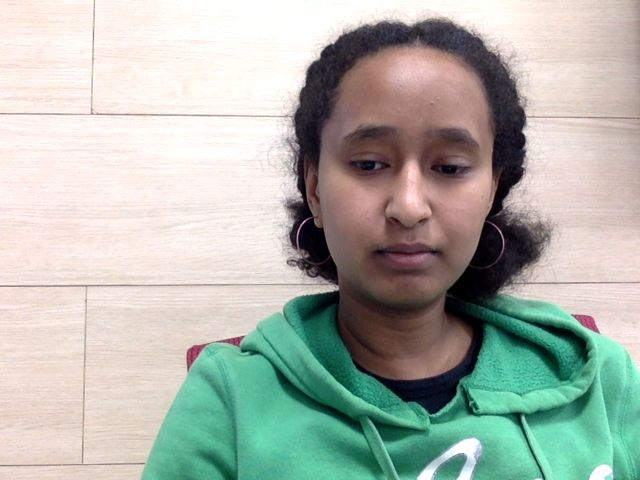

In [124]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [130]:
img = cv2.imread('photo.jpg')
# print (img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
# gray = clahe.apply(g)
print (gray)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=15, minSize=(10, 10), flags=cv2.CASCADE_SCALE_IMAGE)


for (x,y,w,h) in faces:
  cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  roi_gray = gray[y:y+h, x:x+w]
  roi_color = img[y:y+h, x:x+w]
  eyes = eye_cascade.detectMultiScale(roi_gray)
  for (ex,ey,ew,eh) in eyes:
    cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2) 


[[235 236 236 ... 152 148 146]
 [243 243 244 ... 160 156 154]
 [243 243 244 ... 160 156 153]
 ...
 [214 214 213 ... 116 108 107]
 [217 216 215 ... 109 109  99]
 [214 215 216 ... 100 101 108]]


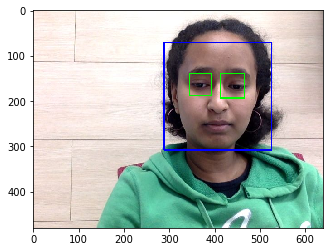

In [131]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
plt.show()

In [0]:
def crop_face(clahe_image, face):
    for (x, y, w, h) in face:
        faceslice = clahe_image[y:y+h, x:x+w]
        faceslice = cv2.resize(faceslice, (2304, 2304))
    facedict["face%s" %(len(facedict)+1)] = faceslice
    return faceslice

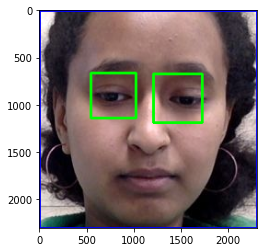

In [133]:
new = crop_face(img, faces)
plt.imshow(new)



2304


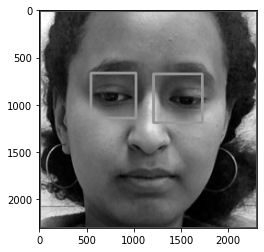

In [134]:
test_image_gray = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)
# Displaying the grayscale image
plt.imshow(test_image_gray, cmap='gray')
print (len(test_image_gray[0]))

In [135]:
print (gray)
print (len(gray[0]))

[[235 236 236 ... 152 148 146]
 [243 243 244 ... 160 156 154]
 [243 243 244 ... 160 156 153]
 ...
 [214 214 213 ... 116 108 107]
 [217 216 215 ... 109 109  99]
 [214 215 216 ... 100 101 108]]
640


Shivangi's part

Shivam's Part
